<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    import re
    
    files = glob(os.path.join(path_to_csv_files, '*.csv'))

    num_filter = r'[0-9]{4}' #Фильтр для user_id

    data_set = pd.DataFrame(columns = feature_names) #Здесь собираем ответ по всем пользователям

    with open(site_freq_path, 'rb') as handle:
        site_freq = pickle.load(handle)
    site_freq_len = len(site_freq)

    for filename in files:
        #Собираем данные по сессиям 
        data = pd.DataFrame(columns = feature_names) #Здесь собираем ответ по каждому пользователю отдельно в нужном формате
        df = pd.read_csv(filename, parse_dates=True) #Сырые данные
        df.timestamp = pd.to_datetime(df.timestamp) #Почему-то дата не подхватывается в read_csv
        user_id = int(re.findall(num_filter, filename)[-1])

        #Заменим названия сайтов на их ID
        df['site'] = df['site'].map(site_freq).apply(lambda x: x[0])
        #Формируем сессию из сайтов с заданым session_length, window_size
        for i in range(1, session_length+1):
            data.loc[:, f'site{i}'] = pd.Series(df.iloc[i-1::window_size, 1].values.tolist())
        #Формируем разницу между посещениями различных сайтов
        for i in range(1, session_length):        
            data.loc[:, f'time_diff{i}'] = ((df.iloc[i::window_size, 0].reset_index() - 
                                             df.iloc[i-1::window_size, 0].reset_index())['timestamp'] / 
                                             np.timedelta64(1,'s'))
        # Запишем 
        data['target'] = user_id
        data['start_hour'] = df.iloc[::window_size, 0].dt.hour.reset_index()['timestamp']
        data['day_of_week'] = df.iloc[::window_size, 0].dt.dayofweek.reset_index()['timestamp']

        data_set = data_set.append(data, ignore_index=True)
    
    data_set['#unique_sites'] = data_set.loc[:, 'site1':'site10'].nunique(axis=1)
    data_set['session_timespan'] = data_set.loc[:,'time_diff1':'time_diff9'].sum(axis=1)
    data_set.fillna(0, inplace=True)
    data_set = data_set.astype('int')
    
    return data_set


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,10,8,8,4,8,5,1,6,2,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,10,8,3,3,8,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,7,5,8,5,8,5,5,6,11,7,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,7,5,8,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                     feature_names=feature_names, session_length=10)

Wall time: 2.1 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1314,2306,4318,4172,4318,4318,4172,4318,2455,4318,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,4869,3050,2897,941,4318,206,252,1663,2354,3722,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,3722,4172,3722,3722,4104,3069,4869,2906,993,3722,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,370,1837,370,3722,3722,3722,3722,3589,3056,348,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,2993,3722,4104,1659,2336,2915,1759,629,1063,629,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                      feature_names=feature_names, session_length=10)

Wall time: 30.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [12]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

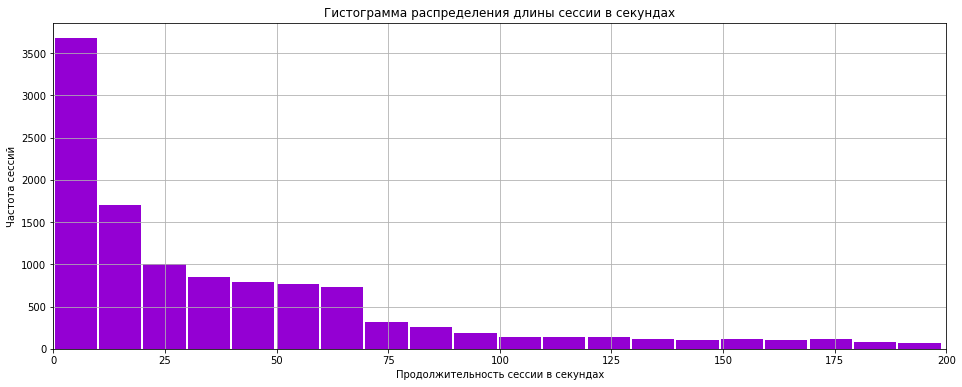

In [67]:
plt.figure(figsize=(16,6))
train_data_10users.loc[train_data_10users.session_timespan < 200, 'session_timespan'].\
                   hist(bins=20, color='darkviolet', rwidth=0.95)
plt.xlabel('Продолжительность сессии в секундах')
plt.ylabel('Частота сессий')
plt.xlim((0, 200))
plt.title('Гистограмма распределения длины сессии в секундах')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

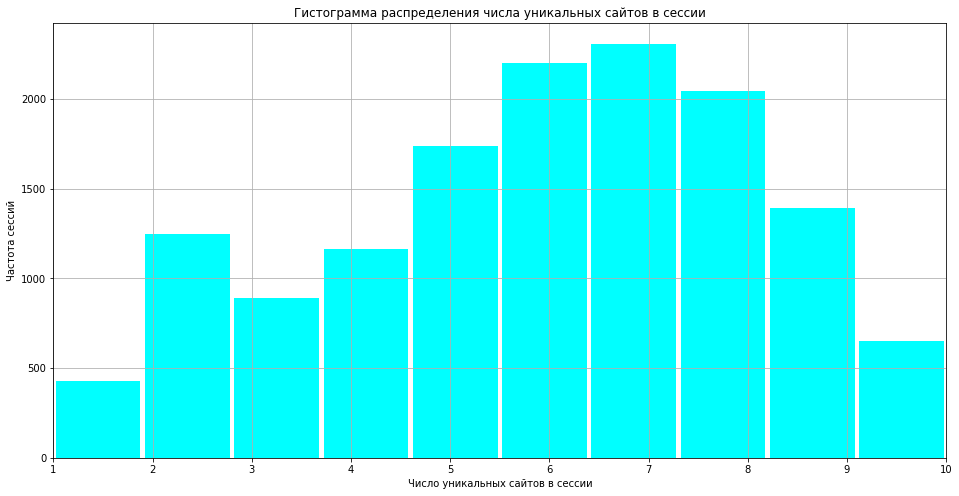

In [64]:
plt.figure(figsize=(16,8))
train_data_10users['#unique_sites'].hist(color='aqua', rwidth=0.95)
plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Частота сессий')
plt.title('Гистограмма распределения числа уникальных сайтов в сессии')
plt.xlim((1,10))

plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

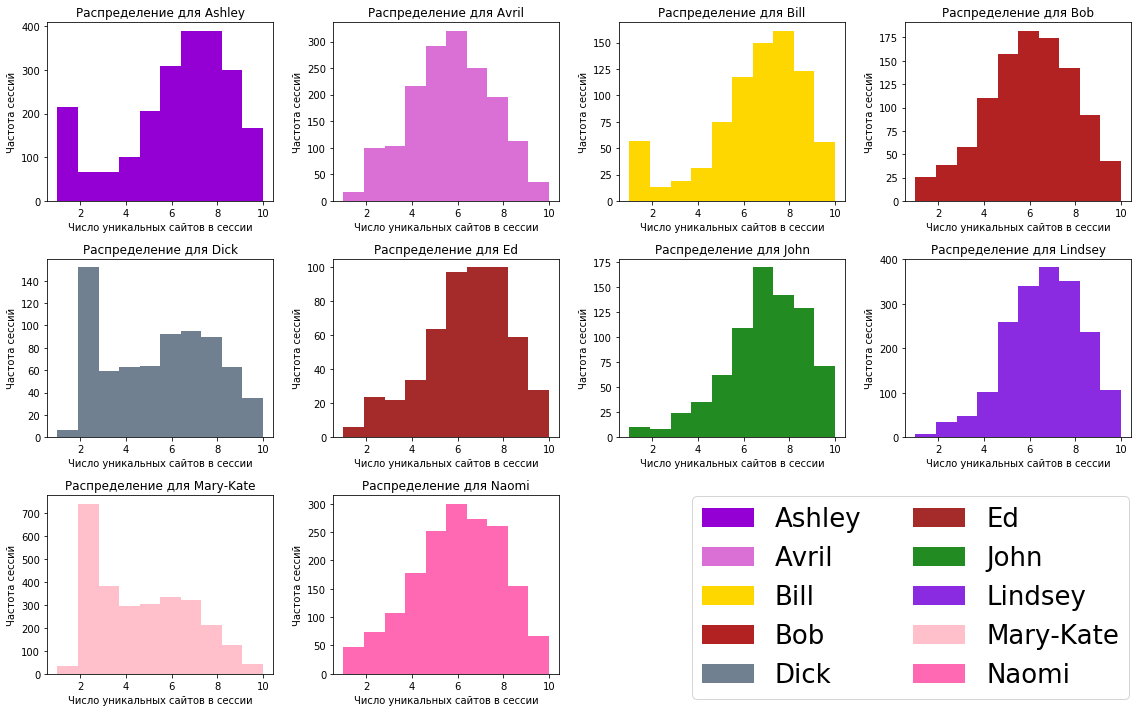

In [26]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    ax = fig.add_subplot(3, 4, idx+1)
    ax.hist(sub_df['#unique_sites'], bins=10, color=color_dic[user], label=user)
    ax.set_title(f'Распределение для {user}')
    ax.set_xlabel('Число уникальных сайтов в сессии')
    ax.set_ylabel('Частота сессий')
    
fig.legend(loc='lower right', fontsize = 26, ncol = 2)
fig.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

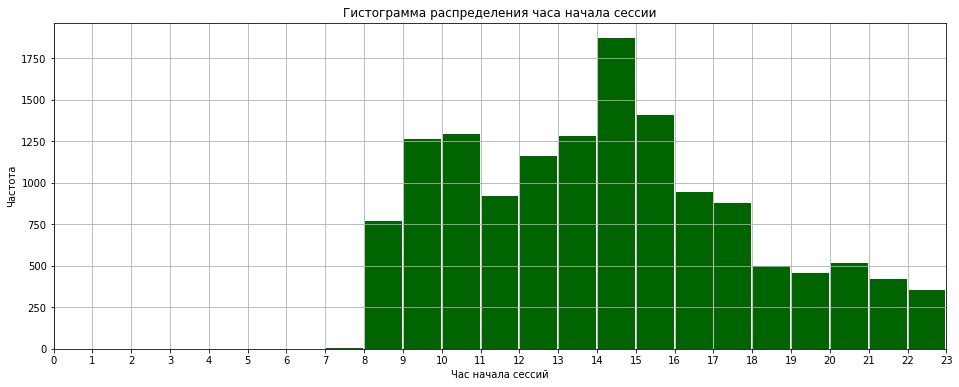

In [63]:
plt.figure(figsize=(16,6))
train_data_10users['start_hour'].hist(bins=[n for n in range(0,24)], color='darkgreen', rwidth=0.95)
plt.xlabel('Час начала сессий')
plt.ylabel('Частота')
plt.title('Гистограмма распределения часа начала сессии')
plt.xlim((0,23))
plt.xticks([n for n in range(0,24)])
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

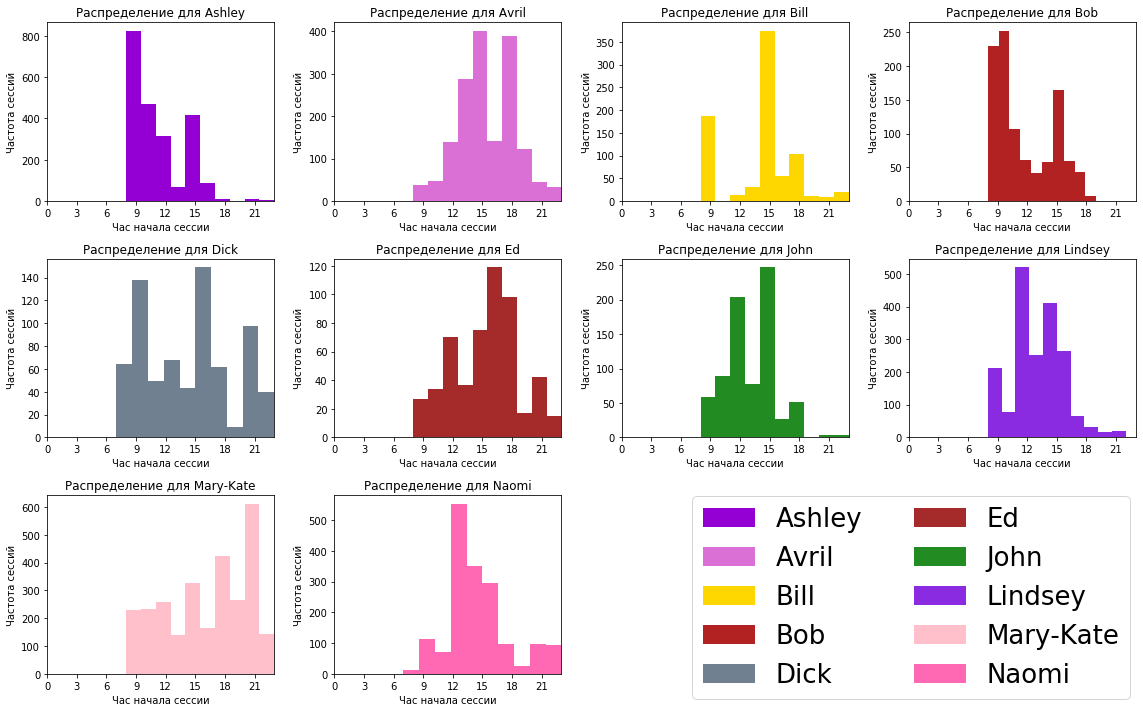

In [55]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    ax = fig.add_subplot(3, 4, idx+1)
    ax.hist(sub_df['start_hour'], color=color_dic[user], label=user)
    ax.set_xlim((0,23))
    ax.set_xticks([n for n in range(0,24,3)])
    ax.set_title(f'Распределение для {user}')
    ax.set_xlabel('Час начала сессии')
    ax.set_ylabel('Частота сессий')

#Черт его знает как приделать к этому графику заголовок и оставить красивый расклад в осях (
fig.legend(loc='lower right', fontsize = 26, ncol = 2)
#можно выполнить fig.suptitle но вместе с tight_layout заголовки наезжают друг на друга
#если убрать tight_layout то с заголовками всё ок, но график сильну ужимается по осям
fig.tight_layout()

plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

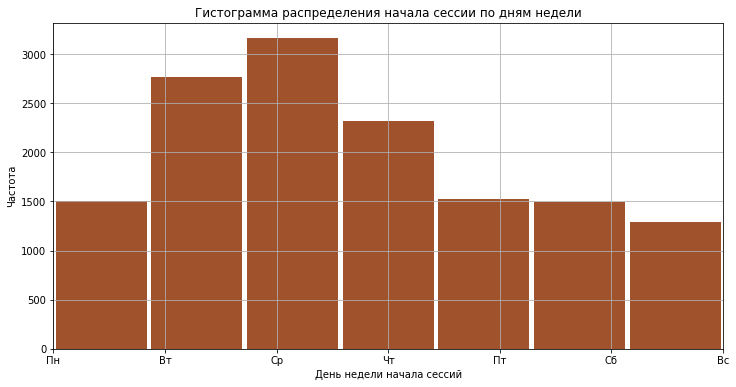

In [70]:
plt.figure(figsize=(12,6))
train_data_10users['day_of_week'].hist(bins=7, color='sienna', rwidth=0.95)
plt.xlabel('День недели начала сессий')
plt.ylabel('Частота')
plt.title('Гистограмма распределения начала сессии по дням недели')
plt.xlim((0,6))
plt.xticks(range(7), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))

plt.show()


**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

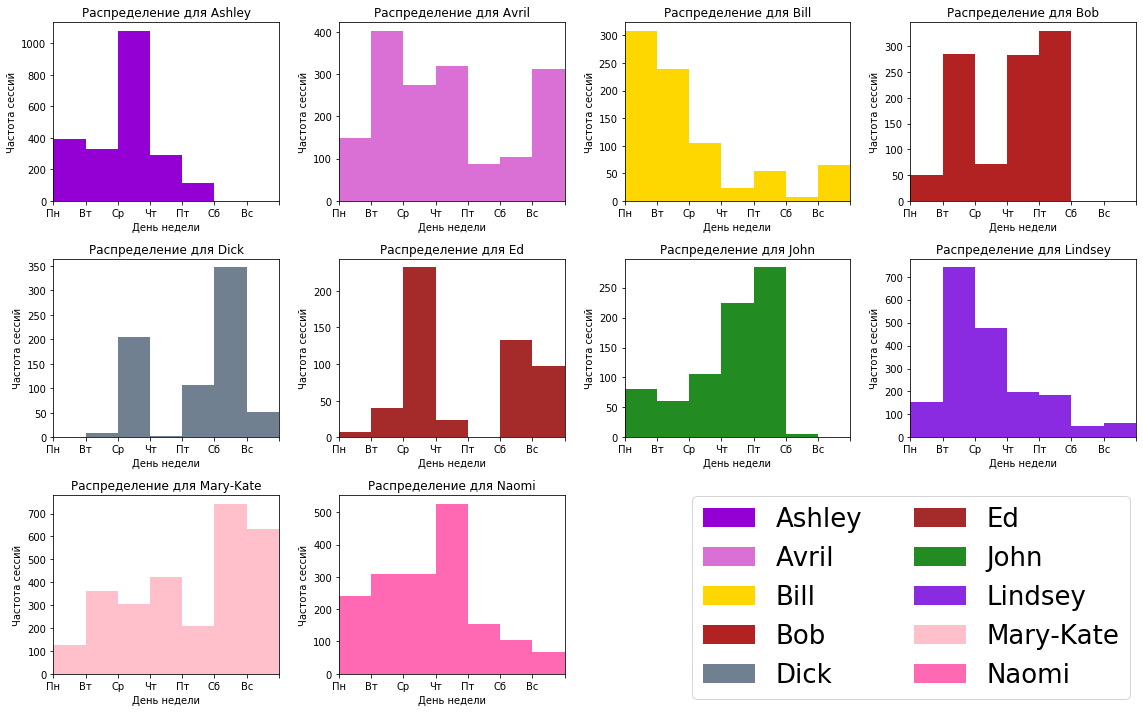

In [85]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    ax = fig.add_subplot(3, 4, idx+1)
    ax.hist(sub_df['day_of_week'], bins=[0,1,2,3,4,5,6,7], color=color_dic[user], label=user)
    ax.set_xlim((0,7))
    ax.set_xticklabels(('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))
    ax.set_title(f'Распределение для {user}')
    ax.set_xlabel('День недели')
    ax.set_ylabel('Частота сессий')

#Черт его знает как приделать к этому графику заголовок и оставить красивый расклад в осях (
fig.legend(loc='lower right', fontsize = 26, ncol = 2)
#можно выполнить fig.suptitle но вместе с tight_layout заголовки наезжают друг на друга
#если убрать tight_layout то с заголовками всё ок, но график сильну ужимается по осям
fig.tight_layout()

plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 